In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset, load_metric
import numpy as np
from utils import ROUGE_L, ROUGE_N, BLEU, tokenize
import matplotlib.pyplot as plt

c:\Users\ANTOINE\Desktop\GIT\natural-language-processing\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")
max_length = 512
dataset = load_dataset("cnn_dailymail", "1.0.0", split="test[:10%]")  # evaluating the model on the test set

Reusing dataset cnn_dailymail (C:\Users\ANTOINE\.cache\huggingface\datasets\cnn_dailymail\1.0.0\1.0.0\3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


In [3]:
# exemple on a sample
article = dataset[4]['article']
summary = dataset[4]['highlights']

prefix = 'summarize:'
input_ids = tokenizer(prefix + article, return_tensors="pt", max_length=max_length, truncation=True).input_ids
output = model.generate(input_ids=input_ids)

print('INPUT:', article)
print('OUTPUT:', tokenizer.decode(output[0], skip_special_tokens=True))
print('GROUND TRUTH:', summary)

INPUT: (CNN)Marco Rubio is all in.  The Republican senator from Florida has announced that he is seeking the Republican presidential nomination, running on an optimistic message that he embodies the promise of the American Dream. With his youthful energy and Hispanic roots, it's tempting to see Rubio as the new blood that the GOP needs in order to compete against Hillary Clinton in 2016.  Yet Rubio has been his own worst enemy on what could have been his two signature issues: immigration reform and Cuba relations.  He holds little appeal to Latino voters.  And unless he can offer new ideas, his climb to the Republican nomination will be steep. Back in 2013, Rubio was a member of the Senate "Gang of 8" that crafted a bipartisan proposal for comprehensive reform, including a path to citizenship for the nation's estimated 11 million undocumented immigrants.  He later distanced himself from the bill after it ran into resistance from House Republicans, and now says he favors a piecemeal app

In [9]:
# testing the performances on the validation set with ROUGE, BLEU


def evaluate(n_iter) : 
    scores = {
        'rouge1' : [],
        'rouge2' : [], 
        'rougeL' : [], 
        'bleu' : []
    }

    true_scores = {
        'rouge1' : [],
        'rouge2' : [], 
        'rougeL' : [], 
        'bleu' : []
    }


    BLEU_ = load_metric("bleu")
    ROUGE_ = load_metric("rouge")
    for i, data in enumerate(dataset) : 
        summary = data['highlights']
        text = data['article']
        input_ids = tokenizer(prefix + text, return_tensors="pt", max_length=max_length, truncation=True).input_ids
        output = model.generate(input_ids=input_ids)
        output = tokenizer.decode(output[0], skip_special_tokens=True)

        #print(f'{i}/10 :\n OUTPUT : {output}\n TRUTH: {summary}')

        output_tokens = tokenize(output)
        true_tokens = tokenize(summary)
        scores['rouge1'].append(ROUGE_N(output_tokens, true_tokens, n=1))
        scores['rouge2'].append(ROUGE_N(output_tokens, true_tokens, n=2))
        scores['rougeL'].append(ROUGE_L(output_tokens, true_tokens))
        scores['bleu'].append(BLEU(output_tokens, true_tokens, n_max = 4))


        ROUGE_.add_batch(predictions=[output_tokens], references=[[true_tokens]])
        BLEU_.add_batch(predictions=[output_tokens], references=[[true_tokens]])

        rouge_ = ROUGE_.compute(use_agregator = False)
        bleu_= BLEU_.compute()

        true_scores['rouge1'].append(rouge_['rouge1'][0])
        true_scores['rouge2'].append(rouge_['rouge2'][0])
        true_scores['rougeL'].append(rouge_['rougeL'][0])
        true_scores['bleu'].append(bleu_['bleu'])

        if i > n_iter - 2 : 
            break

    for dic in [scores, true_scores] : 
        for key in ['rouge1', 'rouge2', 'rougeL', 'bleu'] : 
            dic[key] = np.array(dic[key])

    return scores, true_scores

In [10]:
scores, true_scores = evaluate(n_iter = 20)

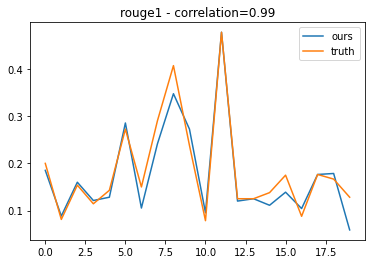

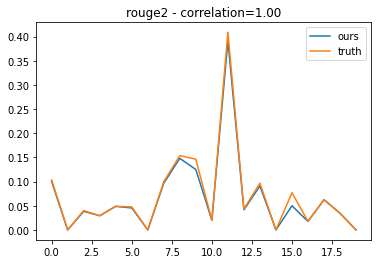

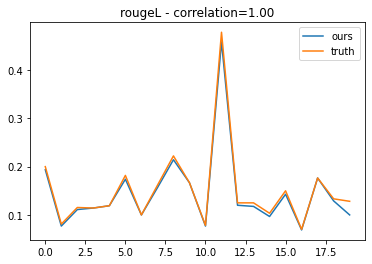

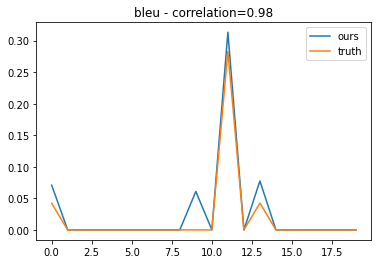

In [12]:
def correl(A, B) : 
    return A/np.linalg.norm(A)  @ B/np.linalg.norm(B)

def plotting(key, sc, tsc) : 
    plt.title(f'{key} - correlation={correl(sc, tsc):.2f}')
    plt.plot(sc, label = 'ours')
    plt.plot(tsc, label = 'truth')
    plt.legend()
    plt.show()


for key in ['rouge1', 'rouge2'] : 
    sc = scores[key][:, 1]
    tsc = true_scores[key][:, 1]
    plotting(key, sc, tsc)

key = 'rougeL'
sc = scores[key]
tsc = true_scores[key][:, 1]
plotting(key, sc, tsc)


key = 'bleu'
sc = scores[key]
tsc = true_scores[key]
plotting(key, sc, tsc)

In [14]:
scores, true_scores = evaluate(n_iter = 1000)

In [25]:
for key in ['rouge1', 'rouge2'] : 
    sc = scores[key].mean(axis = 0) # taking the score average over the 1000 samples
    sc[2] = sc[0] * sc[1] / (sc[0] + sc[1])#computing f1 score

    print(key.upper())
    print(f'OURS :\n\tprecision: {sc[0]:.2f}\n\trecall: {sc[1]:.2f}\n\tf1: {sc[2]:.2f}')
    print(f'TRUTH:\n\tprecision: {sc[0]:.2f}\n\trecall: {sc[1]:.2f}\n\tf1: {sc[2]:.2f}')
    print('==================')

key = 'rougeL'
sc = scores[key].mean() # taking the score average over the 1000 samples
print('ROUGE-L')
print(f'OURS : {sc:.2f}')
print(f'TRUTH: {sc:.2f}')
print('==================')


ROUGE1
OURS :
	precision: 0.41
	recall: 0.16
	f1: 0.12
TRUTH:
	precision: 0.41
	recall: 0.16
	f1: 0.12
ROUGE2
OURS :
	precision: 0.14
	recall: 0.05
	f1: 0.04
TRUTH:
	precision: 0.14
	recall: 0.05
	f1: 0.04
ROUGEL
OURS : 0.12
TRUTH: 0.12
